# Lab Assignment Six: Convolutional Network Architectures

## Preparation
### Getting data in

In [3]:
import pandas as pd
test_labels = pd.read_csv('test_labels.csv')
train_labels = pd.read_csv('train_labels.csv')


y_train = train_labels["Volcano?"].values
y_test = test_labels["Volcano?"].values


from numpy import genfromtxt
X_train = genfromtxt('train_images.csv', delimiter=',')
X_test = genfromtxt('test_images.csv', delimiter=',')

h=w=110
train_labels["Volcano?"].value_counts()

0    6000
1    1000
Name: Volcano?, dtype: int64

In [5]:
import numpy as np

X_train = X_train.astype(np.float32)/12 - 8.2
X_test = X_test.astype(np.float32)/12 - 8.2

### Oversampling data

In [7]:
import numpy as np
volc_ids = y_train.nonzero()
y_o_train = np.concatenate([y_train, y_train[volc_ids],y_train[volc_ids],y_train[volc_ids],y_train[volc_ids],y_train[volc_ids]])
X_o_train = np.concatenate([X_train, X_train[volc_ids],X_train[volc_ids],X_train[volc_ids],X_train[volc_ids],X_train[volc_ids]])
print(y_o_train.nonzero()[0].size)
print(y_o_train.size)

6000
12000


### Dataset example

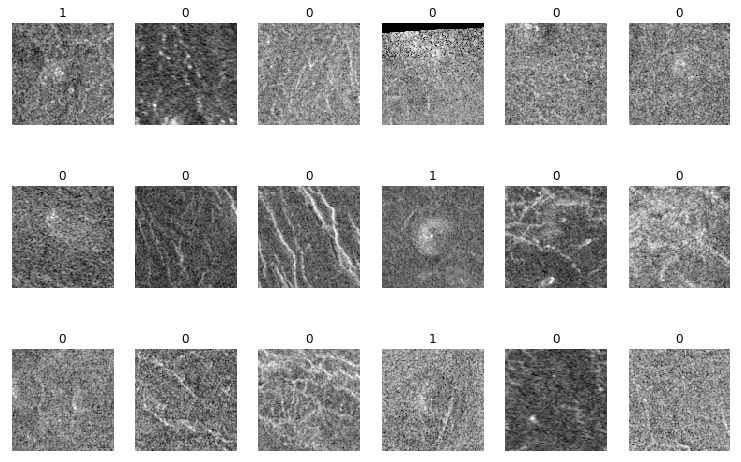

In [8]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_o_train, y_o_train, h, w) # defaults to showing a 3 by 6 subset of the images

### Performance metric
High recall of volcanoes is a priority for this case. The reason for this is that discovery of every volcano or even unformed volcanic structures can reveal a great deal about the geography of Venus. The reason recall of volcanoes on Venus is so important is so we can understand the processes that helped shape our own planet. Since the characteric size, mass and composition are almost the same the formation of volcanoes are very similar to our own planet's past and can help us understand the role volcanoes had in creating life on Earth. In the future, we can analyze these volcanoes to determine areas where life or rare minerals may be.

### Training and testing method
Training and testing strategy would be stratified kfold. This would be a good idea because of the class imbalance. The ratio of anomaly to volcanoes is 6:1. 5 folds would be enough since there are so much data. This would realistic to how the algorithm would be used because it uses a few of the  volcanic data to sift through large amounts of non-volcanoes to find them.

### Subsampling

In [41]:
import numpy as np
ids = np.arange(12000)
np.random.shuffle(ids)
X_train_trunc = X_o_train[ids[:80]]
y_train_trunc = y_o_train[ids[:80]]

ids = np.arange(2734)
np.random.shuffle(ids)

X_test_trunc = X_test[ids[:20]]
y_test_trunc = y_test[ids[:20]]

print("Volcanoes in train out of 80:", y_train_trunc.nonzero()[0].size)

Volcanoes in train out of 80: 47


# Modeling

In [32]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

keras.__version__

'2.2.4'

In [42]:
NUM_CLASSES = 2
y_train_ohe = keras.utils.to_categorical(y_train_trunc, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test_trunc, NUM_CLASSES)

### CNN with Data expansion strategy

In [35]:
# make a CNN with conv layer and max pooling
cnn = Sequential()
cnn.add(Reshape((1,110,110), input_shape=(1,12100)))
cnn.add(Conv2D(filters=16, kernel_size= (3, 3), padding='same', input_shape=(1,110,110)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
# add one layer on flattened output
cnn.add(Flatten())
cnn.add(Dense(NUM_CLASSES))
cnn.add(Activation('softmax'))

cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1, 110, 110)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 110, 16)        15856     
_________________________________________________________________
activation_9 (Activation)    (None, 1, 110, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 55, 8)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 440)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 882       
_________________________________________________________________
activation_10 (Activation)   (None, 2)                 0         
Total para

In [36]:
print(X_train_trunc.shape)
# Let's train the model
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the
#   "channels" dimension expected by Keras
cnn.fit(np.expand_dims(X_train_trunc, axis=1), y_train_ohe,
        batch_size=32, epochs=150,
        shuffle=True, verbose=0)

(80, 12100)


In [37]:
np.expand_dims(X_train_trunc, axis=1).shape

(80, 1, 12100)

In [38]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(5,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test_trunc, axis=1)), axis=1)
        acc_cnn = mt.accuracy_score(y_test_trunc,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test_trunc,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))

    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test_trunc), axis=1)
        acc_mlp = mt.accuracy_score(y_test_trunc,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test_trunc,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

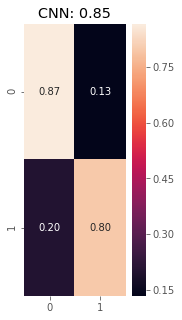

In [40]:
compare_mlp_cnn(cnn,None,X_test,y_test)

### Architecture Investigation and comparison

### Compare to Multilayer Perceptron

In [34]:
# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=X_train_trunc.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train_trunc, y_train_ohe,
        batch_size=32, epochs=150,
        shuffle=True, verbose=0)